<a href="https://colab.research.google.com/github/leptonline/FUnIE-GAN/blob/master/Yahoo_Finance_InvestorStock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install lxml
!pip install yfinance
!pip install requests
!pip install gspread gspread-dataframe

In [88]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

import gspread
from google.auth import default
# Get default credentials for Google Colab
creds, _ = default()

# Initiate Google Colab object with the correct credentials
gc = gspread.authorize(creds)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
workbook  = gc.open('Fiannace_pilot')
worksheet = workbook.worksheet('NVDA_RevByMarket')
worksheet

<Worksheet 'NVDA_RevByMarket' id:1123917550>

In [288]:
df_nvda_revmarket = get_as_dataframe(worksheet, skip_blank_lines=True)
df_nvda_revmarket.dropna(axis=1, how='all', inplace=True)
df_nvda_revmarket.dropna(axis=0, how='all', inplace=True)
df_nvda_revmarket = df_nvda_revmarket.T.reset_index()
df_nvda_revmarket.columns = df_nvda_revmarket.iloc[0]
df_nvda_revmarket = df_nvda_revmarket[1:]
df_nvda_revmarket['Time'] = df_nvda_revmarket['Time'].astype(str)
for col in ['Data Center', 'Gaming', 'Professional Visualization', 'Auto', 'OEM & Other', 'TOTAL']:
    df_nvda_revmarket[col] = pd.to_numeric(df_nvda_revmarket[col], errors='coerce')
# Convert 'Quarter' to PeriodIndex
df_nvda_revmarket['Time'] = pd.PeriodIndex(df_nvda_revmarket['Time'].str.replace(r'(Q\d) FY(\d+)', lambda m: f"20{m.group(2)}{m.group(1)}", regex=True), freq='Q')
# Create a dictionary for renaming
rename_dict = {'Data Center': '1 Data Center',
              'Gaming': '2 Gaming',
              'Professional Visualization': '3 Professional Visualization',
              'Auto': '4 Auto',
              'OEM & Other': '5 OEM & Other',
              }
# Rename the columns
df_nvda_revmarket = df_nvda_revmarket.rename(columns=rename_dict)
df_nvda_revmarket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 1 to 43
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype        
---  ------                        --------------  -----        
 0   Time                          43 non-null     period[Q-DEC]
 1   1 Data Center                 43 non-null     int64        
 2   2 Gaming                      43 non-null     int64        
 3   3 Professional Visualization  43 non-null     int64        
 4   4 Auto                        43 non-null     int64        
 5   5 OEM & Other                 43 non-null     int64        
 6   TOTAL                         43 non-null     int64        
dtypes: int64(6), period[Q-DEC](1)
memory usage: 2.5 KB


In [289]:
df_plot = df_nvda_revmarket[df_nvda_revmarket['Time'].between('2020Q1', '2025Q3')]
df_plot['Time'] = df_plot['Time'].astype(str)
df_plot.head()

<ipython-input-289-5e65bf02a190>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Time'] = df_plot['Time'].astype(str)


,Time,1 Data Center,2 Gaming,3 Professional Visualization,4 Auto,5 OEM & Other,TOTAL
1,2025Q3,30771,3279,486,449,97,35082
2,2025Q2,26272,2880,454,346,88,30040
3,2025Q1,22563,2647,427,329,78,26044
4,2024Q4,18404,2865,463,281,90,22103
5,2024Q3,14514,2856,379,261,66,18120


In [295]:
# prompt: Using dataframe df_nvda_revmarket: i want to plot a stacked bar chart to sum value of each category from Data Center, Gaming, Professional Visualization, Auto and OEM & Other over time as a quarter ascending

import altair as alt

# Reshape the dataframe for plotting
df_melted = pd.melt(df_plot, id_vars=['Time'], value_vars=['1 Data Center', '2 Gaming', '3 Professional Visualization', '4 Auto', '5 OEM & Other'], var_name='Market', value_name='Revenue')

# Sort the DataFrame by Time
df_melted = df_melted.sort_values('Time')

# Create the stacked bar chart using Altair
chart = alt.Chart(df_melted).mark_bar().encode(
    x=alt.X('Time:N', axis=alt.Axis(title='Quarter', labelAngle=-45)), # Use Nominal type for Time
    y=alt.Y('sum(Revenue):Q', axis=alt.Axis(title='Revenue')),
    color=alt.Color('Market:N', ,
    order=alt.Order(
        'Market',
        sort='descending'  # Sort the market segments in ascending order
    )
).properties(
    title="NVIDIA Revenue by Markets",
    width=800
)

chart

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [40]:
nvda = yf.Ticker('NVDA')

In [299]:
nvda.financials

,2024-01-31,2023-01-31,2022-01-31,2021-01-31
Tax Effect Of Unusual Items,0.0,-284130000.0,0.0,0.0
Tax Rate For Calcs,0.12,0.21,0.019,0.017
Normalized EBITDA,35583000000.0,7340000000.0,11351000000.0,5691000000.0
Total Unusual Items,0.0,-1353000000.0,0.0,0.0
Total Unusual Items Excluding Goodwill,0.0,-1353000000.0,0.0,0.0
Net Income From Continuing Operation Net Minority Interest,29760000000.0,4368000000.0,9752000000.0,4332000000.0
Reconciled Depreciation,1508000000.0,1544000000.0,1174000000.0,1098000000.0
Reconciled Cost Of Revenue,16621000000.0,11618000000.0,9439000000.0,6279000000.0
EBITDA,35583000000.0,5987000000.0,11351000000.0,5691000000.0
EBIT,34075000000.0,4443000000.0,10177000000.0,4593000000.0


In [42]:
tsla = yf.Ticker('tsla')

In [43]:
pttep = yf.Ticker('pttep.bk')

In [44]:
interval = '1d'
start = '2024-01-01'
end = datetime.today()


In [45]:
nvda_price = nvda.history(interval=interval, start=start, end=end)
nvda_price

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-01-02 00:00:00-05:00,49.233435,49.284422,47.584790,48.157665,411254000,0.0,0.0
2024-01-03 00:00:00-05:00,47.474811,48.173658,47.309845,47.558792,320896000,0.0,0.0
2024-01-04 00:00:00-05:00,47.756752,48.489596,47.497809,47.987705,306535000,0.0,0.0
2024-01-05 00:00:00-05:00,48.451602,49.536368,48.295633,49.086464,415039000,0.0,0.0
2024-01-08 00:00:00-05:00,49.501378,52.263785,49.468384,52.241787,642510000,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-22 00:00:00-05:00,145.929993,147.160004,141.100006,141.949997,236406200,0.0,0.0
2024-11-25 00:00:00-05:00,141.990005,142.050003,135.820007,136.020004,344941900,0.0,0.0
2024-11-26 00:00:00-05:00,137.699997,139.300003,135.669998,136.919998,190287700,0.0,0.0


<Axes: xlabel='Date'>

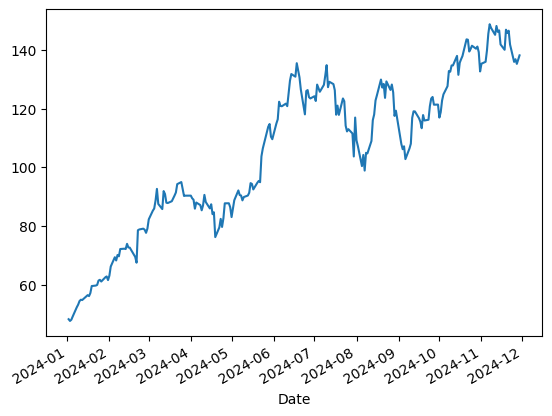

In [46]:
nvda_price['Close'].plot()

<Axes: >

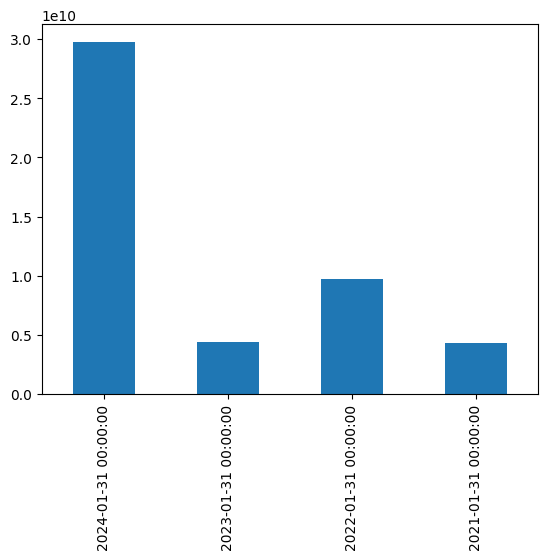

In [47]:
nvda.financials.loc['Net Income'].plot(kind='bar')

In [48]:
nvda.balancesheet

,2024-01-31,2023-01-31,2022-01-31,2021-01-31,2020-01-31
Treasury Shares Number,NaN,NaN,NaN,13800000000.0,13700576960.0
Ordinary Shares Number,24640000000.0,24661365720.0,25060000000.0,24800000000.0,NaN
Share Issued,24640000000.0,24661365720.0,25060000000.0,38600000000.0,NaN
Net Debt,2429000000.0,7564000000.0,8956000000.0,6116000000.0,NaN
Total Debt,11056000000.0,12031000000.0,11831000000.0,7597000000.0,NaN
...,...,...,...,...,...
Allowance For Doubtful Accounts Receivable,NaN,NaN,NaN,-21000000.0,-11000000.0
Gross Accounts Receivable,NaN,NaN,NaN,2450000000.0,1668000000.0
Cash Cash Equivalents And Short Term Investments,25984000000.0,13296000000.0,21208000000.0,11561000000.0,NaN
Other Short Term Investments,18704000000.0,9907000000.0,19218000000.0,10714000000.0,NaN


In [49]:
nvda.cashflow

,2024-01-31,2023-01-31,2022-01-31,2021-01-31,2020-01-31
Free Cash Flow,27021000000.0,3808000000.0,8132000000.0,4694000000.0,NaN
Repurchase Of Capital Stock,-9533000000.0,-10039000000.0,0.0,0.0,NaN
Repayment Of Debt,-1250000000.0,0.0,-1000000000.0,0.0,NaN
Issuance Of Debt,0.0,0.0,4977000000.0,4968000000.0,NaN
Capital Expenditure,-1069000000.0,-1833000000.0,-976000000.0,-1128000000.0,NaN
Interest Paid Supplemental Data,252000000.0,254000000.0,246000000.0,138000000.0,NaN
Income Tax Paid Supplemental Data,6549000000.0,1404000000.0,396000000.0,249000000.0,NaN
End Cash Position,7280000000.0,3389000000.0,1990000000.0,847000000.0,NaN
Beginning Cash Position,3389000000.0,1990000000.0,847000000.0,10896000000.0,NaN
Changes In Cash,3891000000.0,1399000000.0,1143000000.0,-10049000000.0,NaN
